In [1]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [16]:
# Load and prep the data.
# Code taken from Capstone Model_no augmentation notebook. 

# Downloaded capstone project data from Kaggle:
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/download?datasetVersionNumber=2

# Unzipped the archive into a directory on my local machine.

# Absolute path
# my_data_path = "/Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/archive/"

# Relative path
my_data_path = "../Data/archive/"

training_path = my_data_path + "Training/"
testing_path = my_data_path + "Testing/"

# Load the data and begin the exploration.

# Per the source data, images are 512x512.

labels = ["glioma_tumor", "meningioma_tumor","pituitary_tumor", "no_tumor"]

# for i in tqdm(range(20)):

# Load the training data.
X_train = []
y_train = []

# Resize images to a smaller size to simplify processing.
#image_size = 512
image_size = 256

for label in labels:
    folder_path = os.path.join(training_path, label)
    print("Training image folder path:", folder_path)

    # Use tqdm to show progress bar.
    for image_filename in tqdm(os.listdir(folder_path)):
       image = cv2.imread(os.path.join(folder_path, image_filename))
       image = cv2.resize(image,(image_size, image_size))
       X_train.append(image)
       y_train.append(label)



Training image folder path: ../Data/archive/Training/glioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 2247.76it/s]


Training image folder path: ../Data/archive/Training/meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 822/822 [00:00<00:00, 2250.80it/s]


Training image folder path: ../Data/archive/Training/pituitary_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 827/827 [00:00<00:00, 1978.12it/s]


Training image folder path: ../Data/archive/Training/no_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:00<00:00, 2182.45it/s]


In [11]:
# Load the testing data.

for label in labels:
    folder_path = os.path.join(testing_path, label)
    print("Testing image folder path:", folder_path)
    for image_filename in tqdm(os.listdir(folder_path)):
       image = cv2.imread(os.path.join(folder_path, image_filename))
       image = cv2.resize(image,(image_size, image_size))
       X_train.append(image)
       y_train.append(label)

Testing image folder path: ../Data/archive/Testing/glioma_tumor


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 902.53it/s]


Testing image folder path: ../Data/archive/Testing/meningioma_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1604.40it/s]


Testing image folder path: ../Data/archive/Testing/pituitary_tumor


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 666.80it/s]


Testing image folder path: ../Data/archive/Testing/no_tumor


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 2647.43it/s]


In [12]:
# Convert to Numpy arrays for easier manipulation and display the shape of the data.
X_array = np.array(X_train)
y_array = np.array(y_train)

print("X array shape:", X_array.shape)
print("Y array shape:", y_array.shape, y_array.dtype)

X array shape: (3264, 256, 256, 3)
Y array shape: (3264,) <U16


In [13]:
# Get current directory.
print("Current directory:", os.getcwd())
print(os.listdir("../Data/augmented/"))

Current directory: /Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Notebooks
['.DS_Store']


In [14]:

# Augment the no tumor training class images to addresss the class imbalance.
# Augment pictures (rotate, shift, flip).

# Create a separate array that contains the no tumor images.
no_tumor_array = X_array[y_array == "no_tumor"]
print("no_tumor_array shape:", no_tumor_array.shape)
# The array contains 500 images.

# Absolute directory path to save augmented images to.
#augmented_img_path = "/Users/sh/Documents/School/UCSD Extension /Machine Learning and AI/Capstone/Project Files/Data/augmented"

# Relative directory path to save augmented images to.
augmented_img_path = "../Data/augmented/"

# Create and ImageDataGenerator to augment the images (rotate 25 degrees, shift width and height 10%, flip horizontal).
image_augmenter = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Apply the augmentation to the no tumor data.
image_augmenter.fit(no_tumor_array)

# Create augmented images and labels.
# Chose to generate 320 images (256+64 = 320).
image_counter = 0
for batch in image_augmenter.flow(x=no_tumor_array, batch_size=1, save_to_dir=augmented_img_path, save_prefix='no_tumor', save_format='jpeg'):
    image_counter += 1    
# Stop after generating 320 images
    if image_counter == 320:
        break


no_tumor_array shape: (500, 256, 256, 3)


In [6]:

# Create an array for the labels:
no_tumor_labels_array = np.full((320,), "no_tumor", dtype= "<U16")

# Create an empty array for the augmented images
X_augmented = []


# oslsitdir below picking up hidden files? Yes! Use glob instead.

# Read in the augmented images.
# Use tqdm to show progress bar.
augmented_images = glob.glob(augmented_img_path + "/*.jpeg")
#for image_filename in tqdm(os.listdir(augmented_img_path)):
for image_filename in augmented_images:  
    image = cv2.imread(os.path.join(augmented_img_path, image_filename))
    X_augmented.append(image)

print("X_augmented length:", len(X_augmented))



X_augmented length: 320


In [7]:

# Add the augmented no tumor images and labels to the X and y data.
print("X_augmented length:", len(X_augmented))
print("np.array(X_augmented)", np.array(X_augmented).shape)
print("X_array", type(X_array), X_array.shape)


X_array = np.concatenate((X_array, np.array(X_augmented)), axis=0)

print("y_array", type(y_array), y_array.shape)
y_array = np.append(y_array, no_tumor_labels_array) 

print("X_array", type(X_array), X_array.shape)
print("y_array", type(y_array), y_array.shape)



X_augmented length: 320
np.array(X_augmented) (320, 256, 256, 3)
X_array <class 'numpy.ndarray'> (3264, 256, 256, 3)
y_array <class 'numpy.ndarray'> (3264,)
X_array <class 'numpy.ndarray'> (3584, 256, 256, 3)
y_array <class 'numpy.ndarray'> (3584,)


In [8]:
# One hot encode labels.


label_encoder = LabelEncoder()
y_array = label_encoder.fit_transform(y_array)

# One hot encode
y_array_encoded = to_categorical(y_array)
#y_array_encoded = to_categorical(y_array, num_classes=4)

print("y_array_encoded shape:", y_array_encoded.shape)

y_array_encoded shape: (3584, 4)


In [9]:
# Set random seed.
seed =123

# Split into train and test data.
# shuffle=True by default but included it in the function call for clarity.
# Use stratify to make sure the same proportion of each label exists in the training and the test data.
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array_encoded, shuffle=True, stratify=y_array_encoded, random_state=seed)

# Split the data into training and validation sets.
# Chose to use only 10% of the training data for validation due to the number of images available.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=seed)


In [10]:
# Look at the shapes of everything:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2419, 256, 256, 3)
y_train shape: (2419, 4)
X_test shape: (896, 256, 256, 3)
y_test shape: (896, 4)
X_val shape: (269, 256, 256, 3)
y_val shape: (269, 4)


In [11]:
# Load the pre-trained VGG16 model (excluding the top classifier)

# base_vgg16_model = VGG16(include_top=False)]
base_vgg16_model = VGG16(include_top=False, input_shape=(256,256,3))
#  input_shape=IMG_SIZE + (3,)
base_vgg16_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [12]:
# Freeze the layers in the base model

base_vgg16_model.trainable=False
base_vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
# Now create model for fine tuning and add trainable layers to the base VGG16 model. 

# Define the Keras model
model2_finetuned = Sequential()

# Add the vgg16 model as the base model.
model2_finetuned.add(base_vgg16_model)

# Flatten to get the right shape?
model2_finetuned.add(Flatten())

# Add a dropout layer to prevent overfitting. Set dropout rate to 0.5.
model2_finetuned.add(Dropout(rate=0.5))

# Add a dense layer to get ouput. Chose softmax activation since this is a multiclassification problem.
model2_finetuned.add(Dense(4, activation='softmax'))

# Summarize the model.
model2_finetuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4)                 131076    
                                                                 
Total params: 14845764 (56.63 MB)
Trainable params: 131076 (512.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
# Compile the model.
model2_finetuned.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [15]:
# Create a stop callback and train the model.

# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
stop_callback = EarlyStopping(monitor="loss", patience=6)

# Train the model
history = model2_finetuned.fit(x=X_train, y=y_train , validation_data=(X_val, y_val), epochs=100, callbacks=[stop_callback], verbose=2)


Epoch 1/100
76/76 - 123s - loss: 6.5854 - accuracy: 0.7321 - val_loss: 4.0751 - val_accuracy: 0.8587 - 123s/epoch - 2s/step
Epoch 2/100
76/76 - 124s - loss: 2.2794 - accuracy: 0.8921 - val_loss: 3.0062 - val_accuracy: 0.9033 - 124s/epoch - 2s/step
Epoch 3/100
76/76 - 124s - loss: 2.0177 - accuracy: 0.9107 - val_loss: 3.9833 - val_accuracy: 0.9108 - 124s/epoch - 2s/step
Epoch 4/100
76/76 - 124s - loss: 0.8785 - accuracy: 0.9496 - val_loss: 3.9461 - val_accuracy: 0.9071 - 124s/epoch - 2s/step
Epoch 5/100
76/76 - 124s - loss: 1.2094 - accuracy: 0.9487 - val_loss: 4.6039 - val_accuracy: 0.8736 - 124s/epoch - 2s/step
Epoch 6/100
76/76 - 124s - loss: 0.6316 - accuracy: 0.9636 - val_loss: 4.0113 - val_accuracy: 0.9071 - 124s/epoch - 2s/step
Epoch 7/100
76/76 - 124s - loss: 0.5281 - accuracy: 0.9665 - val_loss: 4.3104 - val_accuracy: 0.9145 - 124s/epoch - 2s/step
Epoch 8/100
76/76 - 125s - loss: 0.7056 - accuracy: 0.9669 - val_loss: 3.2296 - val_accuracy: 0.9257 - 125s/epoch - 2s/step
Epoch 9/

In [16]:
# Make predictions on test data
y_predicted = model2_finetuned.predict(X_test)
print("y_predicted shape:", y_predicted.shape)
print("y_test shape:", y_test.shape)

28/28 [==============================] - 37s 1s/step
y_predicted shape: (896, 4)
y_test shape: (896, 4)


In [17]:
# Confusion matrix

# Save a copy of y_test before calling argmax (for development purposes).
y_test_copy = y_test
#y_test = y_test_copy
# Why need argmax?
# Taken from https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
y_test=np.argmax(y_test, axis=1)
y_predicted=np.argmax(y_predicted, axis=1)
#y_predicted=np.argmax(y_predicted)

finetuned_confusion_matrix = confusion_matrix(y_test, y_predicted)

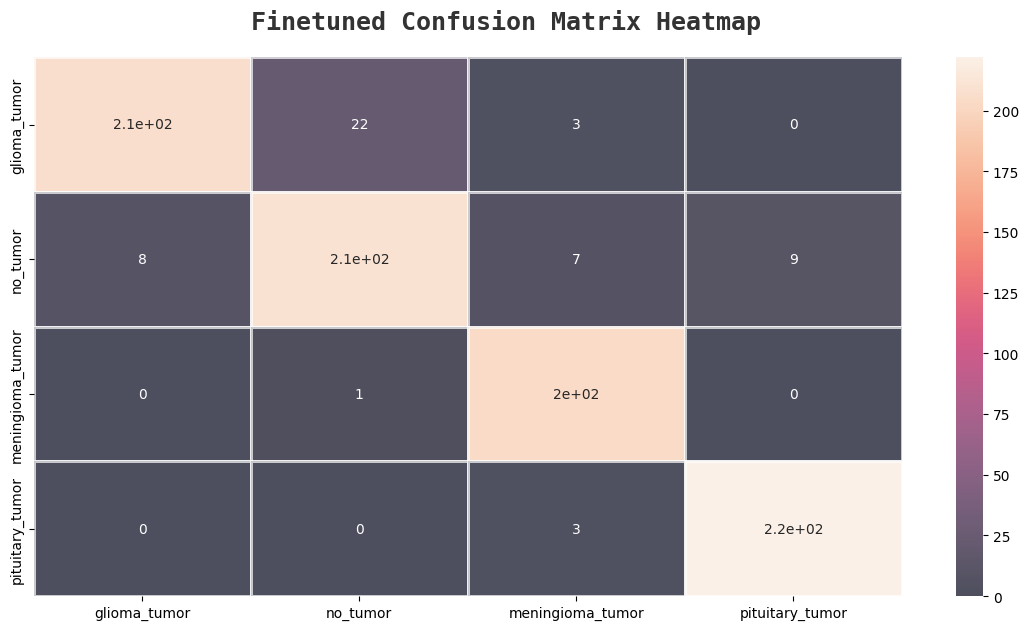

In [18]:
# Plot the confusion matrix as a heatmap.

# Create a 1 x 1 subplot, size (14,7)
fig,ax=plt.subplots(1,1,figsize=(14,7))

# Create labels for the axes.
axis_labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Generate a heatmap for the confusion matrix using the labels for each axis, and write the data in each cell.
sns.heatmap(finetuned_confusion_matrix,ax=ax,xticklabels=axis_labels,yticklabels=axis_labels,annot=True, alpha=0.7,linewidths=2)

# Create text for the heatmap.
fig.text(s="Finetuned Confusion Matrix Heatmap",size=18,fontweight="bold", fontname="monospace",y=0.92,x=0.28,alpha=0.8)

# Show the plot of the confusion matrix.
plt.show()

In [19]:
# Classification report.

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

finetuned_classification_report = classification_report(y_test,y_predicted)
print(finetuned_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       232
           1       0.90      0.90      0.90       234
           2       0.94      1.00      0.97       205
           3       0.96      0.99      0.97       225

    accuracy                           0.94       896
   macro avg       0.94      0.94      0.94       896
weighted avg       0.94      0.94      0.94       896



In [18]:
# Augmented fine tuned results show some improvement over fine tuned results.
# While the training loss and accuracy of the two models were similar, the validation loss and accuracy for the augmented fine tuned model were
# noticeably better (4.4 and 0.93) when compared to the fine tuned model without augmentation (6.7 and 0.90).
# Regarding the test data, much of the confusion matrix improved, notably them meningioma tumor (2) had a recall of 1.0, which means that 
# no false negatives were produced. With the previous fined tuned model the recall was 0.9. Also the ability to distinguish between
# glioma tumors and no tumors was noticeably improved (form 29 to 22 and from 12 to 8).
# The classification report showed that the augmented fine tuned model precision was generally improved for all tumor types except for meningioma tumors.   
# for the different types of tumors, and recall for the augmented fine tuned model improved for all tumor types (0, 2).
# The f1-score for the augmented fine tuned model was generally better (pituitary tumor was a small exception) while overall accuracy was improved
# for the augmented fine tuned model as compared to the fine tuned model (0.94 vs 0.92).

# Scaling:
# The original images were 512x512, and were downsized to 256x256 to reduce the computing pwoer necessary to train and run the model.
# The images could be downsized further to 128x128 if necessary and likely stilla chieve very good reuslts using the fine-tunedd vgg16
# model with augmented data. To further test the scalability of the program, additional data augmentation can be done to reach high enough level of data
# (ex. millions of images) to test to see how the model and code perform. Additional optimizations include hardware (using GPUs insrtead of CPUs),
# deployment (local vs. cloud with potentially many more compute resources), and software (further tuning of the current model or trying newer models
# that may require fewer compute resources).


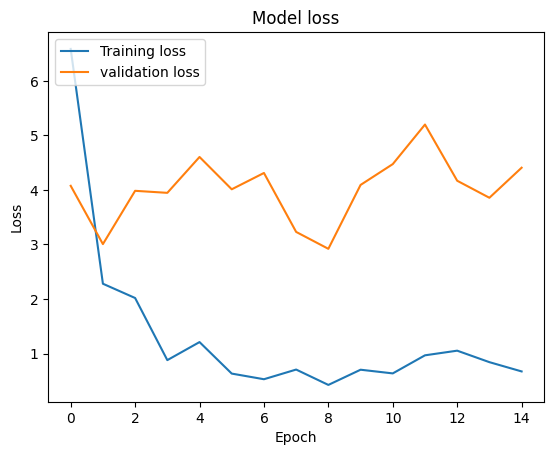

In [21]:

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training loss", "validation loss"], loc="upper left")
plt.show()
